# Core Workflow: Training Models
Compiles "superset" of training data by loading stored training data from specified places & images. This data is then used to train two models: a SVM and a dense neural network. These objects as well as the associated data scaler are saved to file.
  
Date: 2018-09-13  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

# how do change this from manual?
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'sitapur'

data_root='/data/steven/data/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

tile_resolution = resolution
tile_size = 256
tile_pad = 8

# ground truth source: labels, aue+osm, aue+osm2
label_suffix = 'aue+osm2'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

sitapur Sitapur
>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyArea.shp
INFO: Open of `/data/steven/data/sitapur/Sitapur_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Sitapur_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-18
Geometry: Polygon
Feature Count: 1
Extent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyAreaEPSG4326.shp
INFO: Open of `/data/steven/data

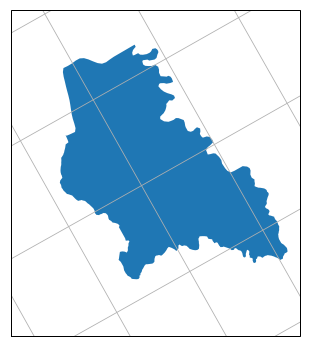

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 164
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[80.58452554952855, 27.493811245326476], [80.61206133747775, 27.493890725222546], [80.61197521086865, 27.518446163412445], [80.5844333100891, 27.518366600693632], [80.58452554952855, 27.493811245326476]]]}


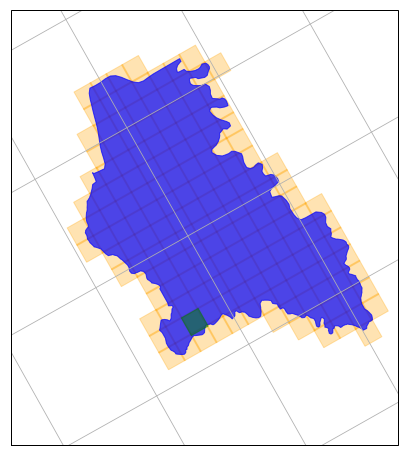

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Specify training data parameters

In [5]:
window = 7    # width of square window

categories = [0,1,4,6]

bands_vir=bands[:-1]
bands_sar=s1_bands
bands_ndvi=None
bands_ndbi=None
bands_osm=None

haze_removal = False

model_id = 'workflow_demo_1'

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+sar 8


### Build training data "superset"
The "superset" of training data used to actually train a model can be a combination of any number of stored training data sets built from particular input stacks. These constituent sets can come from one or many cities. The only requirement is that they are all consistent in construction, ie are built from the same input stack.

In [7]:
place_images = {}
place_images['sitapur'] = ['A','B','C']

X_train, Y_train, X_valid, Y_valid = util_workflow.load_datasets(place_images, data_root, label_suffix, stack_label, window)

calculate total size of training and validation supersets
/data/steven/data/sitapur/sitapur_train_aue+osm2_vir+sar_7w_A.pkl
/data/steven/data/sitapur/sitapur_valid_aue+osm2_vir+sar_7w_A.pkl
(32372, 392) (32372,) (13874, 392) (13874,)
/data/steven/data/sitapur/sitapur_train_aue+osm2_vir+sar_7w_B.pkl
/data/steven/data/sitapur/sitapur_valid_aue+osm2_vir+sar_7w_B.pkl
(32372, 392) (32372,) (13874, 392) (13874,)
/data/steven/data/sitapur/sitapur_train_aue+osm2_vir+sar_7w_C.pkl
/data/steven/data/sitapur/sitapur_valid_aue+osm2_vir+sar_7w_C.pkl
(32372, 392) (32372,) (13874, 392) (13874,)
97116 41622
construct np arrays for supersets
populate superset np arrays
/data/steven/data/sitapur/sitapur_train_aue+osm2_vir+sar_7w_A.pkl
/data/steven/data/sitapur/sitapur_valid_aue+osm2_vir+sar_7w_A.pkl
(32372, 392) (32372,) (13874, 392) (13874,)
/data/steven/data/sitapur/sitapur_train_aue+osm2_vir+sar_7w_B.pkl
/data/steven/data/sitapur/sitapur_valid_aue+osm2_vir+sar_7w_B.pkl
(32372, 392) (32372,) (13874, 39

### Prepare training data for ingestion
This version of the workflow does not include class-balancing

In [8]:
Y_t = Y_train.copy()
Y_v = Y_valid.copy()

Y_t[Y_train==0] = 0
Y_t[Y_train==1] = 1
Y_t[Y_train==4] = 2
Y_t[Y_train==6] = 3

Y_v[Y_valid==0] = 0
Y_v[Y_valid==1] = 1
Y_v[Y_valid==4] = 2
Y_v[Y_valid==6] = 3

categories_reduced = [0,1,2,3]

Y_t_cat = to_categorical(Y_t)
Y_v_cat = to_categorical(Y_v)

### Scale training data

In [9]:
reload(util_workflow)
X_train_scaled, X_valid_scaled, scaler = util_ml.scale_learning_data(X_train, X_valid)
print X_train_scaled.shape, Y_t.shape

(97116, 392) (41622, 392)
(97116, 392) (97116,)


### Train SVM

In [10]:
Yhat_train, Yhat_valid, model = util_ml.train_model_svm(X_train_scaled, X_valid_scaled, Y_t, Y_v, categories=categories_reduced)

evaluate training
0 40269
1 14325
2 31407
3 11115
[[33545   819  3558  2347]
 [ 5830  1405  5908  1182]
 [ 4273   500 25428  1206]
 [ 3091   417  6278  1329]]
97116 61707 0.6353947856172001
evaluate validation
0 17244
1 6123
2 13416
3 4839
[[14309   357  1582   996]
 [ 2595   575  2468   485]
 [ 1845   241 10799   531]
 [ 1410   161  2733   535]]
41622 26218 0.6299072605833453


### Build and train dense neural network

In [11]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)))
network.add(Dropout(0.2))
network.add(layers.Dense(256, activation='relu'))
network.add(Dropout(0.2))
network.add(layers.Dense(len(categories_reduced), activation='softmax'))
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [12]:
network.fit(X_train_scaled, Y_t_cat, epochs=100, batch_size=128)

print "evaluate training"
Yhat_t_prob = network.predict(X_train_scaled)
Yhat_t = Yhat_t_prob.argmax(axis=-1)
confusion = util_ml.calc_confusion(Yhat_t,Y_t,categories_reduced)

print "evaluate validation"
Yhat_v_prob = network.predict(X_valid_scaled)
Yhat_v = Yhat_v_prob.argmax(axis=-1)
confusion = util_ml.calc_confusion(Yhat_v,Y_v,categories_reduced)

Epoch 1/100
97116/97116 [==============================] - 4s 45us/step - loss: 0.8578 - acc: 0.6769
Epoch 2/100
97116/97116 [==============================] - 3s 35us/step - loss: 0.7718 - acc: 0.7067
Epoch 3/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.7286 - acc: 0.7216
Epoch 4/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.6961 - acc: 0.7325
Epoch 5/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.6665 - acc: 0.7443
Epoch 6/100
97116/97116 [==============================] - 4s 36us/step - loss: 0.6437 - acc: 0.7549
Epoch 7/100
97116/97116 [==============================] - 4s 36us/step - loss: 0.6236 - acc: 0.7624
Epoch 8/100
97116/97116 [==============================] - 4s 36us/step - loss: 0.6037 - acc: 0.7692
Epoch 9/100
97116/97116 [==============================] - 4s 37us/step - loss: 0.5839 - acc: 0.7775
Epoch 10/100
97116/97116 [==============================] - 4s 36us/step - loss: 0.5715 - a

97116/97116 [==============================] - 3s 36us/step - loss: 0.3101 - acc: 0.8924
Epoch 82/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.3112 - acc: 0.8921
Epoch 83/100
97116/97116 [==============================] - 3s 35us/step - loss: 0.3123 - acc: 0.8913
Epoch 84/100
97116/97116 [==============================] - 3s 35us/step - loss: 0.3122 - acc: 0.8928
Epoch 85/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.3087 - acc: 0.8931
Epoch 86/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.3104 - acc: 0.8933
Epoch 87/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.3076 - acc: 0.8927
Epoch 88/100
97116/97116 [==============================] - 3s 35us/step - loss: 0.3019 - acc: 0.8955
Epoch 89/100
97116/97116 [==============================] - 3s 35us/step - loss: 0.3009 - acc: 0.8966
Epoch 90/100
97116/97116 [==============================] - 3s 36us/step - loss: 0.3011 - acc: 

### Store all model objects

In [14]:
scaler_filename = data_root+model_id+'_scaler.pkl'
model_filename  = data_root+model_id+'_SVM.pkl'
network_filename = data_root+model_id+'_DLv3.hd5'

if os.path.exists(scaler_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+scaler_filename+')'
elif os.path.exists(model_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+model_filename+')'
elif os.path.exists(network_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+network_filename+')'
else:
    print scaler_filename
    print model_filename
    print network_filename
    pickle.dump(scaler, open(scaler_filename, 'wb'))
    pickle.dump(model, open(model_filename, 'wb'))
    network.save(network_filename)

/data/steven/data/workflow_demo_1_scaler.pkl
/data/steven/data/workflow_demo_1_SVM.pkl
/data/steven/data/workflow_demo_1_DLv3.hd5
